In [1]:
import matplotlib.pyplot as plt
import earthpy.plot as ep
import numpy as np
from utils import *
from unet_model import *
import sys
import os
import warnings
import datetime
if not sys.warnoptions:
    warnings.simplefilter('ignore')
    
os.environ["CUDA_VISIBLE_DEVICES"]="0"

## 1. Load and Preprocess Dataset

In [4]:
X_DICT_TRAIN, Y_DICT_TRAIN, X_DICT_VALIDATION, Y_DICT_VALIDATION = load_data(path = './data/')

Reading images
Images are read


Image shape is:  (627, 851, 8)
Ground Truth's shape is:  (627, 851, 5)


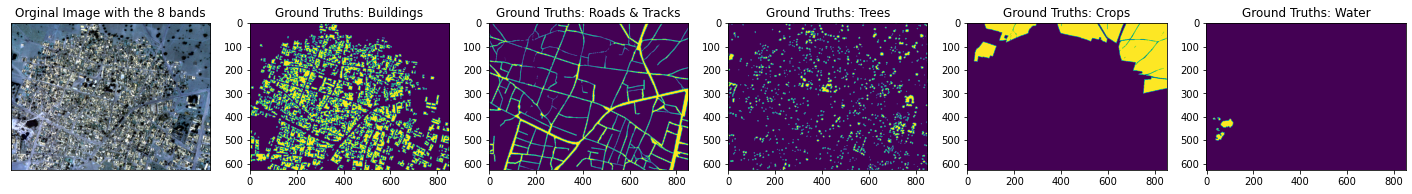

In [5]:
plot_train_data(X_DICT_TRAIN, Y_DICT_TRAIN, image_number = 1)

In [6]:
N_BANDS = 8
N_CLASSES = 1  # buildings, roads, trees, crops and water
N_EPOCHS = 10
PATCH_SZ = 160   # should divide by 16
BATCH_SIZE = 100
TRAIN_SZ = 5000  # train size
VAL_SZ = 500    # validation size
channel='all'#  0: Buildings , 1: Roads & Tracks, 2: Trees , 3: Crops, 4: Water or 'all'


In [7]:
x_train, y_train = get_patches(X_DICT_TRAIN, Y_DICT_TRAIN, n_patches=TRAIN_SZ, sz=PATCH_SZ, channel=channel)
x_val, y_val = get_patches(X_DICT_VALIDATION, Y_DICT_VALIDATION, n_patches=VAL_SZ, sz=PATCH_SZ, channel=channel)
y_train = y_train[:,:, :,2:3]
y_val = y_val[:,:, :,2:3]

Generated 5000 patches
Generated 500 patches


In [42]:
print("Train shape is: {} and Train Ground truth shape is: {}".format(x_train.shape, y_train.shape))
print("Validation shape is: {} and Validation Ground truth shape is: {}".format(x_val.shape, y_val.shape))

Train shape is: (5000, 160, 160, 8) and Train Ground truth shape is: (5000, 160, 160, 1)
Validation shape is: (500, 160, 160, 8) and Validation Ground truth shape is: (500, 160, 160, 1)


## 2. Build and Train  U-net Model

In [5]:
model = unet_model( n_classes= N_CLASSES,
                    im_sz= PATCH_SZ,
                    n_channels = N_BANDS,
                    n_filters_start = 32,
                    growth_factor = 2,
                    upconv=True)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 8) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 160, 160, 32) 2336        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 160, 160, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 80, 80, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [7]:
callbacks_list = get_callbacks()

model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS,
          verbose=1, shuffle=True, validation_data=(x_val, y_val), callbacks=callbacks_list)

Train on 5000 samples, validate on 500 samples
Epoch 1/10
4900/5000 [============================>.] - ETA: 0s - loss: 0.1174 - accuracy: 0.9494 - precision: 0.9764 - recall: 0.7740
Epoch 00001: val_loss improved from inf to 0.13955, saving model to ./models/UNet_(11-26-2020 , 20:05:29)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./models/UNet_(11-26-2020 , 20:05:29)/assets
5000/5000 [==============================] - 60s 12ms/sample - loss: 0.1174 - accuracy: 0.9494 - precision: 0.9764 - recall: 0.7744 - val_loss: 0.1396 - val_accuracy: 0.9439 - val_precision: 0.9737 - val_recall: 0.7424
Epoch 2/10
4900/5000 [============================>.] - ETA: 0s - loss: 0.1141 - accuracy: 0.9507 - precision: 0.9769 - recall: 0.7808
Epoch 00002: val_loss did not improve from 0.13955
5000/5000 [==============================] - 22s 4ms/sample - loss: 0.1143 - accuracy: 0.9506 - precision: 0.9769 - recall: 0.7808 - val_loss: 0.1

## 3. Load trained Model

In [2]:
model_path = "/home/amir/Desktop/Tree Counting/Counting Trees/models/UNet_(11-26-2020 , 19:51:28)"

In [3]:
model =  model_load(model_path)

## 4. Evaluate trained Model

In [8]:
y_pred = model.predict(x_val)

In [71]:
number = 123 #56 ,34
img = y_pred[number,:,:,:]

opened_img, number_of_objects, blob_labels = post_processing(img)
print("Number of Trees: {}".format(number_of_objects[-1]))

Number of Trees: 27


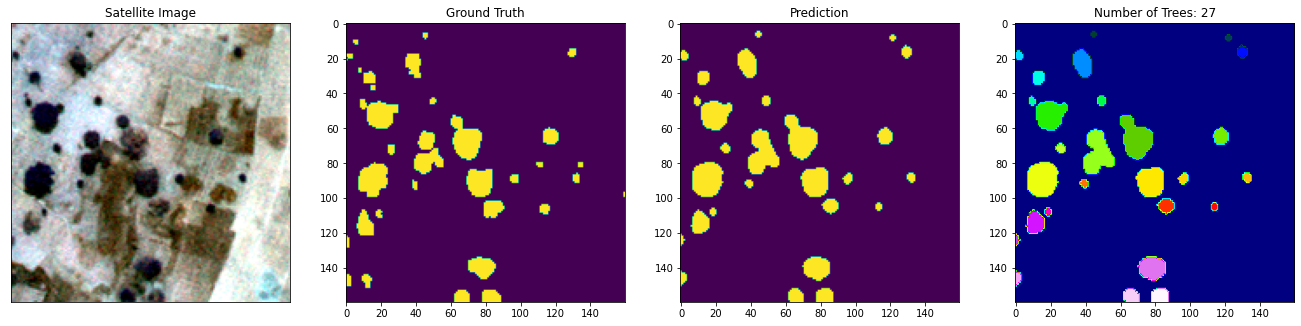

In [72]:
f, axs = plt.subplots(1,4, figsize=(23,23))

ep.plot_rgb(x_val[number,:,:,:].transpose([2,0,1]),
            rgb=[0, 1, 2],
            title="Satellite Image",
            stretch=True,
            ax=axs[0])

axs[1].imshow(y_val[number,:,:,:])
axs[1].set_title("Ground Truth")

axs[2].imshow(opened_img)
axs[2].set_title("Prediction")


axs[3].imshow(blob_labels, cmap='gist_ncar')
axs[3].set_title("Number of Trees: {}".format(number_of_objects[-1]))

f.show()
